In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr, norm
import joblib
from tensorflow import keras

In [2]:
df_temporal = pd.read_csv('/content/drive/MyDrive/Dissertation/processed_ncd_data.csv')
df_multiclass = pd.read_csv('/content/drive/MyDrive/Dissertation/clean_diabetes_data.csv')
df_mortality = pd.read_csv('/content/drive/MyDrive/Dissertation/processed_mortality_data.csv')

xgb_model = joblib.load('/content/drive/MyDrive/Dissertation/xgboost_model.pkl')
lstm_model = keras.models.load_model('/content/drive/MyDrive/Dissertation/diabetes_lstm_model.keras')

In [3]:
merged = pd.merge(
df_temporal.groupby(['country','year']).agg({'prevalence':'mean'}).reset_index(),
df_mortality[['country','year','Diabetes Mellitus']],
on=['country','year'],
how='inner'
)
merged

,country,year,prevalence,Diabetes Mellitus
0,afghanistan,1990,0.105382,2108
1,afghanistan,1991,0.107359,2120
2,afghanistan,1992,0.109459,2153
3,afghanistan,1993,0.111672,2195
4,afghanistan,1994,0.113974,2231
...,...,...,...,...
5965,zimbabwe,2015,0.109184,3176
5966,zimbabwe,2016,0.109326,3259
5967,zimbabwe,2017,0.109561,3313
5968,zimbabwe,2018,0.109908,3381


In [4]:
valid_data = merged.dropna(subset=['prevalence','Diabetes Mellitus'])
pearson_corr, pearson_p = pearsonr(valid_data['prevalence'], valid_data['Diabetes Mellitus'])
print(f"Pearson correlation between prevalence and mortality: {pearson_corr:.4f} (p={pearson_p:.4f})")

Pearson correlation between prevalence and mortality: -0.0041 (p=0.7527)


In [5]:
# XGBoost validation
target_col = 'diabetes_type'
le = LabelEncoder()
y_encoded = le.fit_transform(df_multiclass[target_col])
X_numeric = df_multiclass.drop(columns=[target_col]).select_dtypes(include=[np.number])

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy = cross_val_score(xgb_model, X_numeric, y_encoded, cv=skf, scoring='accuracy')
precision = cross_val_score(xgb_model, X_numeric, y_encoded, cv=skf, scoring='precision_macro')
recall = cross_val_score(xgb_model, X_numeric, y_encoded, cv=skf, scoring='recall_macro')
f1 = cross_val_score(xgb_model, X_numeric, y_encoded, cv=skf, scoring='f1_macro')

In [7]:
print("\nXGBoost Cross-Validation Results:")
print(f"Accuracy: {accuracy.mean():.4f}")
print(f"Precision: {precision.mean():.4f}")
print(f"Recall: {recall.mean():.4f}")
print(f"F1-Score: {f1.mean():.4f}")


XGBoost Cross-Validation Results:
Accuracy: 0.9061
Precision: 0.9129
Recall: 0.9066
F1-Score: 0.9049


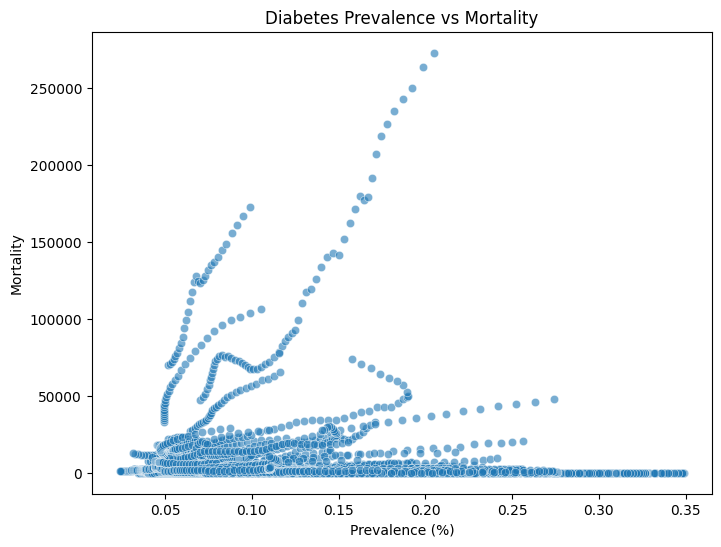

In [8]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=valid_data, x='prevalence', y='Diabetes Mellitus', alpha=0.6)
plt.title('Diabetes Prevalence vs Mortality')
plt.xlabel('Prevalence (%)')
plt.ylabel('Mortality')
plt.show()

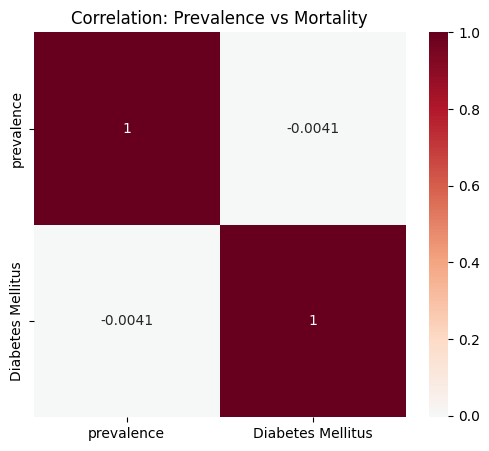

In [9]:
plt.figure(figsize=(6,5))
corr_matrix = valid_data[['prevalence','Diabetes Mellitus']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation: Prevalence vs Mortality')
plt.show()

In [10]:
def correlation_ci(x, y, conf=0.95):
    r, p = pearsonr(x, y)
    n = len(x)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - (1 - conf) / 2)
    lo, hi = np.tanh([z - z_crit * se, z + z_crit * se])
    return r, p, (lo, hi)

r, p, ci = correlation_ci(valid_data['prevalence'], valid_data['Diabetes Mellitus'])
print(f"Correlation: {r:.4f}, p={p:.4f}, 95% CI [{ci[0]:.4f}, {ci[1]:.4f}], n={len(valid_data)}")


Correlation: -0.0041, p=0.7527, 95% CI [-0.0294, 0.0213], n=5970
